In [2]:
import random
import torch
#from selenium import webdriver
import torch.nn.functional as F
from matplotlib import pyplot as plt
#from selenium.webdriver.common.by import By

# Dataset Collection

In [21]:
driver = webdriver.Chrome()

In [24]:
count = 0
names = []
for i in range(1, 289):
    url = f"https://www.looktamil.com/babynames/show/girl-names-{i}"
    driver.get(url)
    spans = driver.find_elements(By.CSS_SELECTOR, "span.fw-500.babyname-color-F")
    for span in spans:
        names.append(span.text)
        count += 1
print(count)

21126


In [32]:
with open("girl_names.txt", "w") as f:
    for name in names:
        f.write(name + "\n")

# EDA

In [4]:
names =  open("Dataset/girl_names.txt").read().splitlines()
names[:10]

['Aaby',
 'Aadanya',
 'Aadarshini',
 'Aadhika',
 'Aadhila',
 'Aadhini',
 'Aadhira',
 'Aadhithyan',
 'Aadhiya',
 'Aadirai']

In [5]:
s = ""
for name in names:
   s += name
s = sorted(set(s))
print(f"Characters in each sample:\n{s}\n")
print(f"Total characters : {len(s)}\n")
print(f"Dataset length: {len(names)}")

Characters in each sample:
[' ', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

Total characters : 52

Dataset length: 21126


# Data preprocessing

In [6]:
names_processed = []
chars = []
for name in names:
    name = name.lower()
    name = name.replace(' ', '')
    names_processed.append(name)

for name in names_processed:
    for ch in name:
        chars.append(ch)
chars = sorted(set(chars))
print(f"Characters in each sample:\n{chars}\n")
print(f"Total characters : {len(chars)}\n")

Characters in each sample:
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

Total characters : 26



In [7]:
names_processed[:10]

['aaby',
 'aadanya',
 'aadarshini',
 'aadhika',
 'aadhila',
 'aadhini',
 'aadhira',
 'aadhithyan',
 'aadhiya',
 'aadirai']

In [8]:
random.seed(11739827)
random.shuffle(names_processed)

In [9]:
names_processed[:10]

['pranita',
 'jasmiya',
 'absha',
 'mushanthitha',
 'arana',
 'jarusha',
 'senthusha',
 'kabila',
 'ayesha',
 'saruhi']

In [10]:
stoi = {}
itos = {}
for i, char in enumerate(chars):
    stoi[char] = i+1
    itos[i+1] = char
stoi['.'] = 0
itos[0] = '.'

In [11]:
def process_dataset(dataset, block_size, stoi):
    xtr = []
    ytr = []
    for name in dataset:
        context = [0] * block_size
        name += '.'
        for ch in name:
            ix = stoi[ch]
            xtr.append(context)
            ytr.append(ix)
            context = context[1:] + [ix]
    return torch.tensor(xtr), torch.tensor(ytr)

In [12]:
n1 = int(0.8 * len(names_processed))
n2 = int(0.9 * len(names_processed))
print(n1, n2)

16900 19013


In [13]:
xtr, ytr = process_dataset(names_processed[:n1], 3, stoi)
xval, yval = process_dataset(names_processed[n1:n2], 3, stoi)
xtest, ytest = process_dataset(names_processed[n2:], 3, stoi)

In [14]:
print(f"x-Training set length: {len(xtr)}")
print(f"y-Training set length: {len(ytr)}")
print(f"x-validation set length: {len(xval)}")
print(f"y-validation set length: {len(yval)}")
print(f"x-test set length: {len(xtest)}")
print(f"y-test set length: {len(ytest)}")

x-Training set length: 154462
y-Training set length: 154462
x-validation set length: 19265
y-validation set length: 19265
x-test set length: 19292
y-test set length: 19292


# Model building

In [57]:
class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn(fan_in, fan_out) / (fan_in) ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias 
        return self.out

    def parameters(self):
        return [self.weight, self.bias] if self.bias is not None else [self.weight]


class BatchNorm1d:
    def __init__(self, dim, momentum = 0.001, eps = 4e-5, Training = True):
        self.eps = eps
        self.momentum = momentum
        self.Training = Training
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.mean_running = torch.zeros(dim)
        self.var_running = torch.zeros(dim)

    def __call__(self, x):
        if self.Training:
            xmean = x.mean(0, keepdims = True)
            xvar = x.var(0, keepdims = True)
        else:
            xmean = self.mean_running
            xvar = self.var_running
            
        self.out = self.gamma * (x - xmean) / torch.sqrt(xvar + self.eps) + self.beta
        
        if self.Training:
            with torch.no_grad():
                self.mean_running = (1 - self.momentum) * self.mean_running + (self.momentum * xmean)
                self.var_running = (1 - self.momentum) * self.var_running + (self.momentum * xvar)
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []


class Embedding:
    def __init__(self, vocab_size, n_embd):
        self.C = torch.randn(vocab_size, n_embd)

    def __call__(self, x):
        self.out = self.C[x]   
        self.out = self.out.view(self.out.shape[0], -1)
        return self.out

    def parameters(self):
        return [self.C]


class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [58]:
torch.manual_seed(875745764)
block_size = 3
n_embd = 10
n_hidden = 100
vocab_size = 27
model = Sequential([
    Embedding(vocab_size, n_embd),
    
    Linear(block_size*n_embd, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),
    
    Linear(n_hidden, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),

    Linear(n_hidden, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),

    Linear(n_hidden, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),

    Linear(n_hidden, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),
    
    Linear(n_hidden, vocab_size),
    BatchNorm1d(vocab_size)
])

with torch.no_grad():
    model.layers[-2].weight *= 0.1
    for layer in model.layers:
        if isinstance(layer, Linear):
            layer.weight *= 4/3
            
parameters = model.parameters()
for p in parameters:
    p.requires_grad = True
    
print(f"Total parameters : {sum([p.nelement() for p in parameters])}")

Total parameters : 47551


# Model training

In [163]:
batch_size = 32
loss_ls = []
for layer in model.layers:
    layer.Training = True
    
for i in range(200000):
    #Create mini batches
    ix = torch.randint(0, xtr.shape[0], (batch_size, ))
    x = xtr[ix]

    #Forward pass
    logits = model(x)
    loss = F.cross_entropy(logits, ytr[ix])
    
    #Backward pass
    for layer in model.layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    #Update
    if i < 100000:
        lr = 0.1
    else:
        lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    #Track stats
    loss_ls.append(loss.item())

In [164]:
loss_ls = torch.tensor(loss_ls)
ls = []
loss_ls = loss_ls.view(-1, 1000).mean(1, keepdims = True)
for loss in loss_ls:
    ls.append(loss.item())

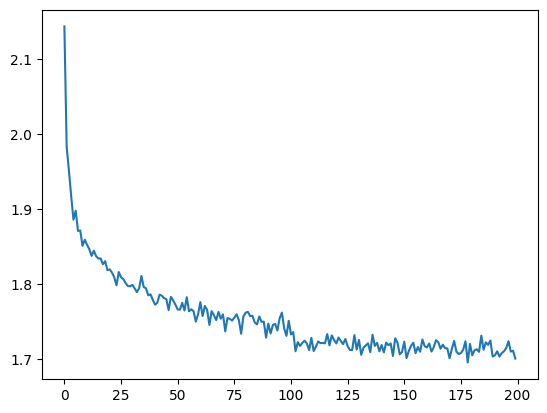

In [165]:
plt.plot(ls)

In [166]:
ls[-5:]

[1.7145453691482544,
 1.7235994338989258,
 1.7098232507705688,
 1.7109493017196655,
 1.7004754543304443]

# EMA (Exploratory Model Analysis)

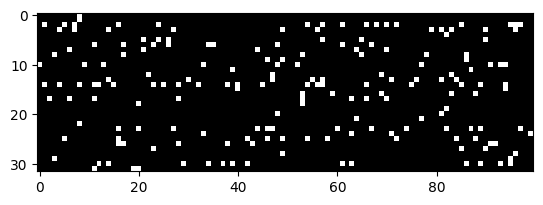

In [167]:
#Check activation distribution
plt.imshow(abs(model.layers[3].out) > 0.99, cmap = "gray", interpolation = "nearest")

Text(0, 0.5, 'Activation gradients')

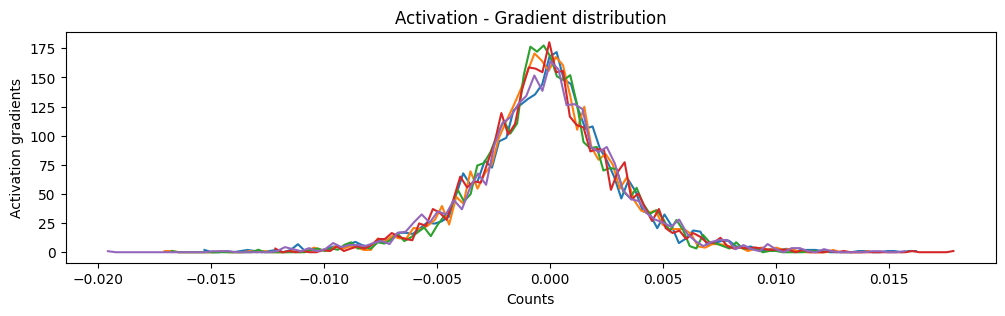

In [187]:
plt.figure(figsize = (12,3))
for layer in model.layers:
    if isinstance(layer, Tanh):
        counts, g = torch.histogram(layer.out.grad, density = True)
        plt.plot(g[:-1].detach(), counts.detach())
plt.title("Activation - Gradient distribution")
plt.xlabel("Counts")
plt.ylabel("Activation gradients")

Update - Data Ratio: 0.00589704466983676
Update - Data Ratio: -0.00018379362882114947
Update - Data Ratio: -7.971336890477687e-05
Update - Data Ratio: -7.700503920204937e-05
Update - Data Ratio: -7.617704250151291e-05
Update - Data Ratio: -7.386859215330333e-05
Update - Data Ratio: -0.00018140800239052624


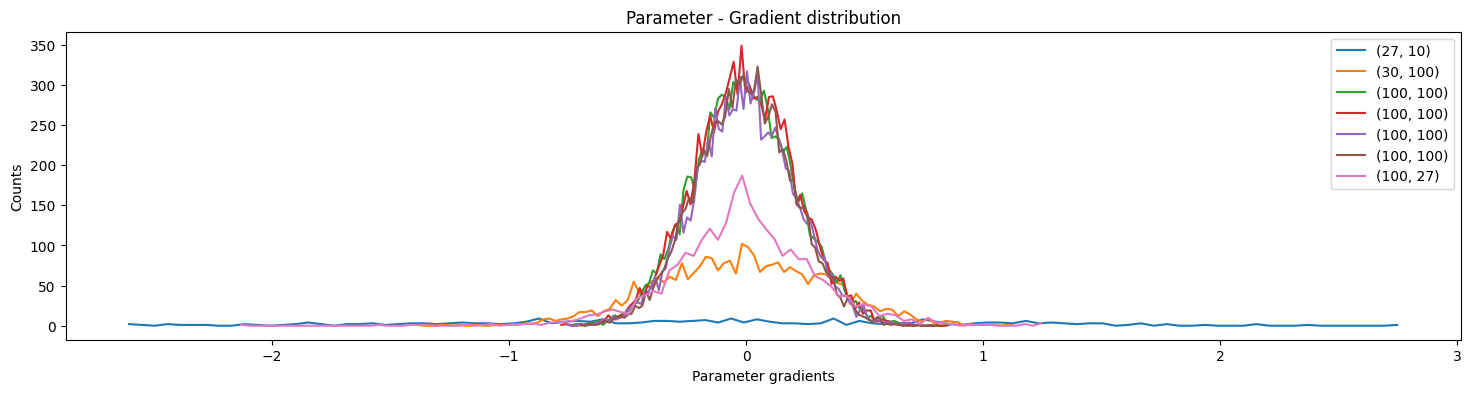

In [211]:
plt.figure(figsize = (18,4))
legends = []
for p in parameters:
    if p.ndim == 2:
        print(f"Update - Data Ratio: {lr*p.grad.std() / p.data.std().log10()}")
        legends.append(tuple(p.shape))
        counts, g = torch.histogram(p)
        plt.plot(g[:-1].detach(), counts.detach())

plt.title("Parameter - Gradient distribution")
plt.xlabel("Parameter gradients")
plt.ylabel("Counts")
plt.legend(legends)

In [190]:
for p in parameters:
    print(p.ndim)

2
2
1
1
1
2
1
1
1
2
1
1
1
2
1
1
1
2
1
1
1
2
1
1
1


In [186]:
for p in parameters:
    if p.ndim > 1:
        print(p.shape)
        print((0.1 * p.abs().std() / p.grad.abs().std().log()))

torch.Size([27, 10])
tensor(-0.0137, grad_fn=<DivBackward0>)
torch.Size([30, 100])
tensor(-0.0040, grad_fn=<DivBackward0>)
torch.Size([100, 100])
tensor(-0.0023, grad_fn=<DivBackward0>)
torch.Size([100, 100])
tensor(-0.0022, grad_fn=<DivBackward0>)
torch.Size([100, 100])
tensor(-0.0022, grad_fn=<DivBackward0>)
torch.Size([100, 100])
tensor(-0.0021, grad_fn=<DivBackward0>)
torch.Size([100, 27])
tensor(-0.0041, grad_fn=<DivBackward0>)


# Model evaluation

In [59]:
for layer in model.layers:
    layer.Training = False
x = xval
logits = model(x)
print(f"Validation loss : {F.cross_entropy(logits, yval).item()}")

Validation loss : 39.87662124633789


In [77]:
# 3127 parameter model - train_loss : 2.50 - val_loss : 2.49
# 13000 parameter model + nembd : 1 - train_loss : 2.43 - val_loss: 2.44
# 14000 parmater model + nembd : 3 - train_loss : 1.76 - val_loss : 1.77
# 46497 parmater model + nembd : 10 - train_loss : 1.63 - val_loss : 1.73

# Inference

In [62]:
torch.manual_seed(875745764)
for layer in layers:
    layer.Training = False
for i in range(10):
    context = [0,0,0]
    while True:
        with torch.no_grad():
            x = torch.tensor([context])
            for layer in layers:
                x = layer(x)
            p_dis = F.softmax(x, dim = -1)
            ix = torch.multinomial(p_dis, num_samples = 1)
            if ix == 0:
                break
            print(itos[ix.item()], end = '')
            context = context[1:] +  [ix.item()]
    print()

akanitharmesha
risha
keasmithulanika
teasani
sembhana
ashri
jana
safa
ileenaayinesharshini
pranandhuleka


In [48]:
'''model2:
-------------------------------
waabphiarhe

sre
ka
fkiasmahuia
noiyhieamarirhe
shnnanasuha
jaisha
fj
iaeenhaiiueazerbshinei

model 3:
-------------------------------
akanatina
vithra
karaksasmiga
dhaniyateamaritheeshna
sasha
deeksha
famithya
arunesharbalinee
nihankulee
vopmiya

model 4:
-------------------------------
akanitharmesha
risha
keasmithulanika
teasani
sembhana
ashri
jana
safa
ileenaayinesharshini
pranandhuleka'''

'model 3\n\nakanatina\nvithra\nkaraksasmiga\ndhaniyateamaritheeshna\nsasha\ndeeksha\nfamithya\narunesharbalinee\nnihankulee\nvopmiya'